In [7]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

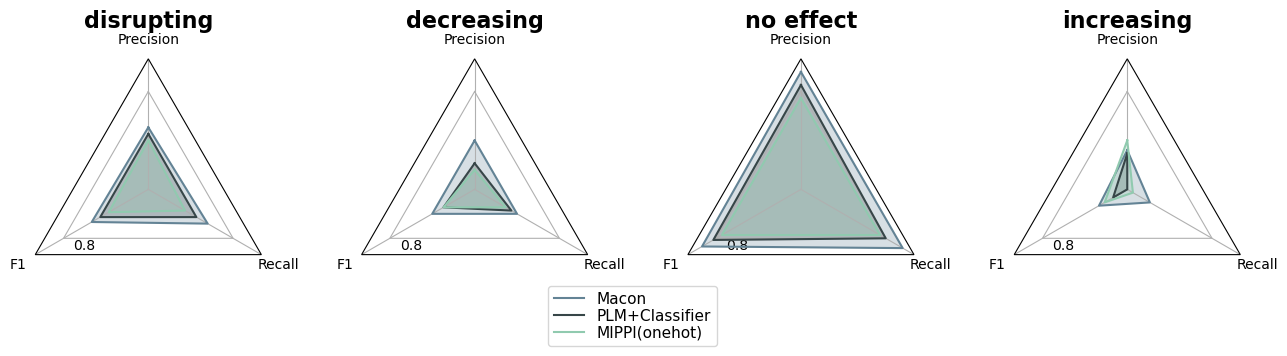

In [37]:
data = [
    ['Precision', 'F1', 'Recall'],
    ('disrupting', [
        [0.69, 0.70, 0.71],  # Macon
        [0.67, 0.67, 0.67],  # PLM+Classifier
        [0.65, 0.64, 0.63],  # MIPPI(onehot)
    ]),
    ('decreasing', [
        [0.65, 0.65, 0.65],  # Macon
        [0.58, 0.61, 0.63],  # PLM+Classifier
        [0.56, 0.61, 0.61],  # MIPPI(onehot)
    ]),
    ('no effect', [
        [0.86, 0.85, 0.86],  # Macon
        [0.82, 0.81, 0.80],  # PLM+Classifier
        [0.78, 0.78, 0.78],  # MIPPI(onehot)
    ]),
    ('increasing', [
        [0.62, 0.60, 0.58],  # Macon
        [0.61, 0.55, 0.50],  # PLM+Classifier
        [0.65, 0.58, 0.52],  # MIPPI(onehot)
    ])
]

N = 3
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['#638395','#374648','#90CAAF']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    
    ax.set_title(title, weight='bold', fontsize=16, position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_rgrids([0.3,0.8],fontsize=10,angle=130.)
    ax.set_rlim(0.5,0.9)

# add legend relative to top-left plot
labels = ('Macon', 'PLM+Classifier', 'MIPPI(onehot)')
legend = axs[1].legend(labels, loc=(0.78, -.10),
                              labelspacing=0.1, fontsize=11)

#fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',horizontalalignment='center', color='black', weight='bold',size='large')
plt.savefig('method.png',dpi=300)
plt.show()

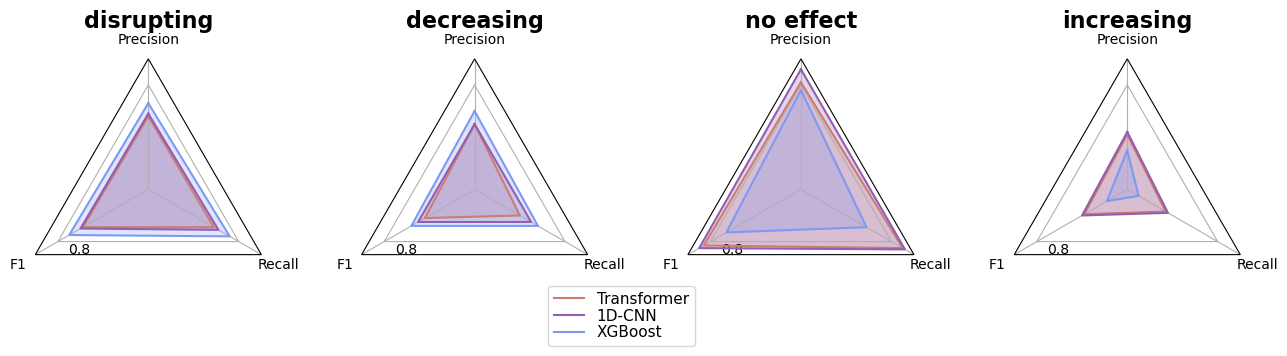

In [38]:
# Transformer, 1D-CNN, and XGBoost data
data = [
    ['Precision', 'F1', 'Recall'],
    ('disrupting', [
        [0.68, 0.69, 0.69],  # Transformer
        [0.69, 0.70, 0.71],  # 1D-CNN
        [0.73, 0.75, 0.76],  # XGBoost
    ]),
    ('decreasing', [
        [0.65, 0.62, 0.60],  # Transformer
        [0.65, 0.65, 0.65],  # 1D-CNN
        [0.70, 0.68, 0.68],  # XGBoost
    ]),
    ('no effect', [
        [0.81, 0.83, 0.85],  # Transformer
        [0.86, 0.85, 0.86],  # 1D-CNN
        [0.78, 0.73, 0.69],  # XGBoost
    ]),
    ('increasing', [
        [0.61, 0.59, 0.57],  # Transformer
        [0.62, 0.60, 0.58],  # 1D-CNN
        [0.55, 0.49, 0.45],  # XGBoost
    ])
]

N = 3
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['#cc7c71','#925eb0','#7e99f4',]
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    
    ax.set_title(title, weight='bold', fontsize=16, position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_rgrids([0.3,0.8],fontsize=10,angle=130.)
    ax.set_rlim(0.4,0.9)

# add legend relative to top-left plot
labels = ('Transformer', '1D-CNN', 'XGBoost')
legend = axs[1].legend(labels, loc=(0.78, -.10),
                              labelspacing=0.1, fontsize=11)

#fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',horizontalalignment='center', color='black', weight='bold',size='large')
plt.savefig('network.png',dpi=300)
plt.show()

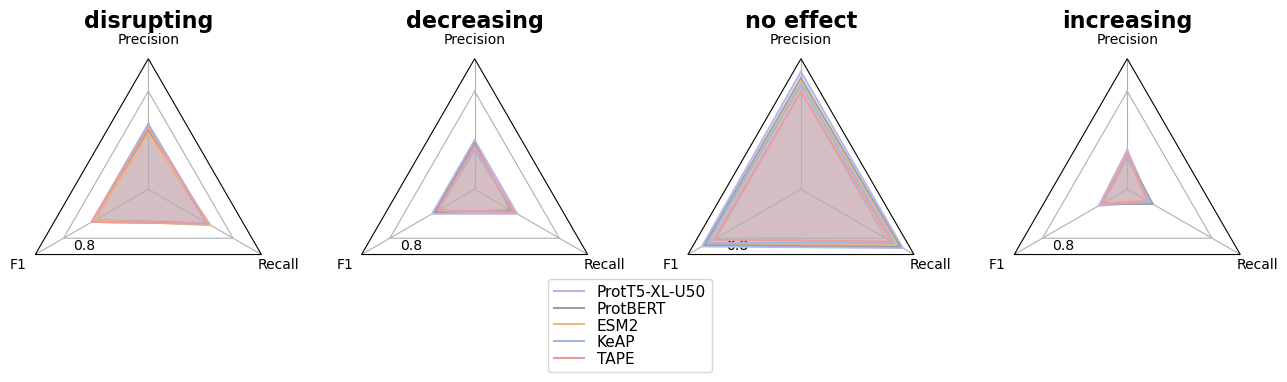

In [40]:
data = [
    ['Precision', 'F1', 'Recall'],
    ('disrupting', [
        [0.69, 0.70, 0.71],  # ProtT5-XL-U50
        [0.68, 0.69, 0.71],  # ProtBERT
        [0.67, 0.69, 0.72],  # ESM2_33
        [0.70, 0.70, 0.71],  # KeAP
        [0.69, 0.70, 0.71],  # TAPE
    ]),
    ('decreasing', [
        [0.65, 0.65, 0.65],  # ProtT5-XL-U50
        [0.64, 0.64, 0.63],  # ProtBERT
        [0.63, 0.63, 0.64],  # ESM2_33
        [0.62, 0.63, 0.64],  # KeAP
        [0.63, 0.63, 0.64],  # TAPE
    ]),
    ('no effect', [
        [0.86, 0.85, 0.86],  # ProtT5-XL-U50
        [0.84, 0.84, 0.85],  # ProtBERT
        [0.83, 0.83, 0.84],  # ESM2_33
        [0.82, 0.83, 0.83],  # KeAP
        [0.80, 0.81, 0.82],  # TAPE
    ]),
    ('increasing', [
        [0.62, 0.60, 0.58],  # ProtT5-XL-U50
        [0.60, 0.59, 0.59],  # ProtBERT
        [0.61, 0.59, 0.57],  # ESM2_33
        [0.60, 0.59, 0.58],  # KeAP
        [0.61, 0.59, 0.57],  # TAPE
    ])
]

N = 3
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['#b7b7eb','#9d9ea3','#eab883', '#9bbbe1', '#f09ba0']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    
    ax.set_title(title, weight='bold', fontsize=16, position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_rgrids([0.3,0.8],fontsize=10,angle=130.)
    ax.set_rlim(0.5,0.9)

# add legend relative to top-left plot
labels = ('ProtT5-XL-U50', 'ProtBERT', 'ESM2', 'KeAP', 'TAPE')
legend = axs[1].legend(labels, loc=(0.78, -.20),
                              labelspacing=0.1, fontsize=11)

#fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',horizontalalignment='center', color='black', weight='bold',size='large')
plt.savefig('plm.png',dpi=300)
plt.show()

In [ ]:
from scipy import stats

macon_f1 = [0.70, 0.65, 0.85, 0.60] 
plm_classifier_f1 = [0.67, 0.61, 0.81, 0.55]

t_stat, p_value = stats.ttest_rel(macon_f1, plm_classifier_f1)

print(f"t-statistic: {t_stat}, p-value: {p_value}")


t-statistic: 9.797958971132694, p-value: 0.002259503579778215
